# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from workspace_utils import active_session

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f"azdias.shape{azdias.shape}")
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
azdias.iloc[130:140]

azdias.shape(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
130,-1,2,2,4.0,1,5,2,4,4,3,1,1981,12.0,0,2,1.0,1.0,1.0,1.0,1.0,1.0,1,14,1.0,3,5,4,7,4,4,5,4,4,4,7,5,4,7,1,0.0,0.0,1,5,18.0,1.0,0.0,5.0,NaN,0.0,9.0,8.0,0.0,1.0,2.0,1997.0,W,2.0,7,7A,41,0.0,3.0,2.0,0.0,0.0,3.0,6.0,2.0,7.0,5.0,0.0,2.0,2.0,0.0,453.0,2.0,3.0,2.0,0.0,1.0,3.0,3.0,3.0,3.0,5.0
131,-1,3,1,6.0,5,2,4,2,3,1,2,1970,2.0,1,3,26.0,8.0,8.0,4.0,6.0,3.0,1,11,5.0,6,4,4,4,7,6,4,6,2,5,5,3,3,4,1,0.0,0.0,2,2,21.0,2.0,0.0,1.0,2.0,1.0,9.0,1.0,0.0,3.0,5.0,2003.0,W,8.0,5,5C,33,2.0,0.0,0.0,0.0,5.0,5.0,6.0,2.0,6.0,2.0,1.0,4.0,5.0,3.0,656.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,2.0,1.0
132,-1,1,1,5.0,2,5,2,5,5,2,4,1990,5.0,1,2,33.0,11.0,10.0,5.0,6.0,3.0,1,15,1.0,7,7,7,5,7,2,1,7,4,2,2,2,6,5,0,0.0,0.0,2,2,20.0,3.0,0.0,2.0,NaN,3.0,9.0,1.0,0.0,3.0,5.0,1992.0,W,2.0,1,1B,14,3.0,1.0,0.0,0.0,1.0,5.0,3.0,4.0,4.0,3.0,3.0,5.0,4.0,5.0,681.0,3.0,2.0,1.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0
133,-1,1,2,6.0,3,4,3,5,5,3,4,0,5.0,0,-1,0.0,0.0,0.0,0.0,5.0,2.0,0,0,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,-1,4,1,2.0,3,1,5,1,2,5,5,0,1.0,0,2,6.0,2.0,1.0,1.0,1.0,1.0,1,5,5.0,4,6,3,6,6,7,7,4,3,3,3,3,1,1,2,0.0,0.0,1,3,0.0,1.0,0.0,6.0,NaN,6.0,4.0,15.0,0.0,3.0,1.0,1992.0,W,4.0,9,9D,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,6.0,2.0,3.0,3.0,1.0,1.0,7.0,409.0,1.0,3.0,3.0,2.0,4.0,4.0,2.0,3.0,7.0,3.0
135,-1,4,2,3.0,2,3,3,5,4,3,1,1962,1.0,0,1,21.0,6.0,5.0,3.0,1.0,1.0,1,8,3.0,4,3,1,2,4,5,7,1,2,6,6,6,2,3,3,0.0,0.0,2,3,20.0,3.0,0.0,6.0,6.0,2.0,9.0,22.0,0.0,8.0,1.0,1991.0,W,4.0,7,7B,41,0.0,0.0,0.0,2.0,5.0,1.0,1.0,6.0,2.0,2.0,2.0,1.0,4.0,3.0,367.0,1.0,4.0,3.0,2.0,5.0,4.0,3.0,4.0,8.0,5.0
136,-1,3,2,2.0,1,5,3,5,4,5,1,1992,2.0,0,-1,1.0,1.0,1.0,1.0,2.0,1.0,0,14,1.0,5,4,5,4,2,5,7,5,7,4,4,6,7,3,-1,0.0,0.0,-1,5,20.0,1.0,0.0,6.0,NaN,6.0,9.0,3.0,0.0,1.0,1.0,1992.0,W,5.0,6,6A,31,1.0,0.0,0.0,1.0,5.0,2.0,1.0,6.0,2.0,3.0,4.0,2.0,2.0,6.0,311.0,1.0,3.0,3.0,2.0,5.0,4.0,2.0,4.0,8.0,5.0
137,-1,3,1,6.0,3,4,3,5,5,3,4,0,5.0,0,-1,0.0,0.0,0.0,0.0,5.0,2.0,0,0,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,-1,3,1,NaN,5,3,4,2,4,1,3,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,8,NaN,3,6,4,6,7,1,4,5,5,5,2,3,4,4,1,0.0,0.0,1,2,18.0,2.0,0.0,2.0,1.0,3.0,3.0,1.0,0.0,1.0,1.0,2014.0,W,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,3.0
139,-1,3,1,3.0,3,2,4,1,2,3,5,0,10.0,0,3,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,3,4,4,2,7,1,4,6,2,5,5,3,4,2,2,0.0,0.0,2,3,0.0,1.0,0.0,4.0,NaN,4.0,7.0,21.0,0.0,3.0,1.0,1992.0,W,3.0,7,7A,41,0.0,0.0,0.0,1.0,5.0,2.0,1.0,6.0,2.0,2.0,3.0,2.0,1.0,5.0,293.0,1.0,3.0,3.0,2.0,5.0,3.0,1.0,3.0,9.0,5.0


In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [5]:
print(f"feat_info.shape{feat_info.shape}")
feat_info.iloc[0:85]

feat_info.shape(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
'''
This function is to help us find the codes used to denote missing or unknown values in the azdias dataset.
These details are extracted form the feat_info dataset which is fetched from the AZDIAS_Feature_Summary.csv file
The output of this function is to be used in recoding these missing or unknown values to NaN values later on.
'''
def get_missing_or_unknown_codes(feature):
    missing_or_unknown_String = feat_info.loc[feat_info['attribute']==feature]['missing_or_unknown'].values[0]
    #arrayObj = np.fromstring(missing_or_unknown_String[1:-1],dtype=np.int,sep=",")
    missing_or_unknown_String = missing_or_unknown_String.strip('[')
    missing_or_unknown_String = missing_or_unknown_String.strip(']')
    arrayObj = missing_or_unknown_String.split(",")
    targetArray = []
    for value in arrayObj:
        if value == '':
            pass
        else:
            try:
               val = int(value)
               targetArray.append(val)
            except ValueError:
                targetArray.append(value)
    return targetArray


In [7]:
# Testing the get_missing_or_unknown_codes(...) function on one of the features of the dataset
get_missing_or_unknown_codes('CAMEO_INTL_2015')

[-1, 'XX']

In [8]:
def count_all_nulls(dataset):
    return dataset.isnull().sum().sum()

In [9]:
NaturallyMissingValues = count_all_nulls(azdias)
NaturallyMissingValues

4896838

In [10]:
'''
This function takes the a dataset and finds the codes for the missing or unknown values 
from the feat_info dataset in AZDIAS_Feature_Summary.csv. Consequently, it recodes these values as NaN values.
Keep in consideration that: this fucntions does not auto-convert all non-numerical values in the dataset.
Additional conversion steps are to be applied in order to ensure all values are 
numerically encoded and ready for processing.
'''
def recode_dataset(dataset):
    for feature in feat_info['attribute'].tolist():
        missing_codes = get_missing_or_unknown_codes(feature)
        if len(missing_codes)>0:
            dataset = dataset.replace({feature: missing_codes}, np.nan)
    return dataset

In [11]:
# Identify missing or unknown data values and convert them to NaNs.

azdias = recode_dataset(azdias)

In [12]:
TotalMissingValues = count_all_nulls(azdias)
TotalMissingValues

8373929

In [13]:
'''
Checking that codes for unknown or missing values have been replaced with NaNs.
Note that some values are still in string format. These will be handled later on.
'''
uniquevalues = []
for column in azdias.columns.values:
    line = [column,azdias[column].unique()]
    uniquevalues.append(line)

In [14]:
uniquevalues

[['AGER_TYP', array([ nan,   2.,   3.,   1.])],
 ['ALTERSKATEGORIE_GROB', array([  2.,   1.,   3.,   4.,  nan])],
 ['ANREDE_KZ', array([1, 2])],
 ['CJT_GESAMTTYP', array([  2.,   5.,   3.,   4.,   1.,   6.,  nan])],
 ['FINANZ_MINIMALIST', array([3, 1, 4, 2, 5])],
 ['FINANZ_SPARER', array([4, 5, 2, 3, 1])],
 ['FINANZ_VORSORGER', array([3, 2, 1, 5, 4])],
 ['FINANZ_ANLEGER', array([5, 2, 1, 4, 3])],
 ['FINANZ_UNAUFFAELLIGER', array([5, 4, 3, 1, 2])],
 ['FINANZ_HAUSBAUER', array([3, 5, 2, 4, 1])],
 ['FINANZTYP', array([4, 1, 6, 5, 2, 3])],
 ['GEBURTSJAHR',
  array([   nan,  1996.,  1979.,  1957.,  1963.,  1943.,  1964.,  1974.,
          1975.,  1941.,  1993.,  1946.,  1988.,  1991.,  1966.,  1949.,
          1982.,  1972.,  1990.,  1985.,  1989.,  1948.,  1935.,  1997.,
          1994.,  1987.,  2002.,  1950.,  1965.,  1969.,  1978.,  1958.,
          1944.,  1967.,  1977.,  1960.,  1970.,  1973.,  1971.,  1937.,
          1947.,  1926.,  1954.,  1981.,  1962.,  1992.,  2008.,  1976.,
   

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

In [16]:
Azdias_nan_count = azdias.isna().sum()

In [17]:
Azdias_nan_percentage = Azdias_nan_count/len(azdias)*100

In [18]:
# Shown below are columns sorted by the amount of data missing per column as percentage to the total number of rows.

Azdias_nan_percentage = Azdias_nan_percentage.sort_values(ascending=False)
Azdias_nan_percentage

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

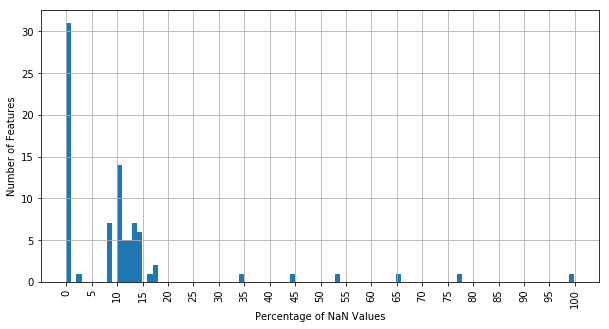

In [19]:
# Investigate patterns in the amount of missing data in each column.
%matplotlib inline
fig = plt.figure(figsize=(10,5))
plt.hist(Azdias_nan_percentage.values,100)
plt.ylabel("Number of Features");
plt.xlabel("Percentage of NaN Values");
plt.xticks(np.arange(0, 101, step=5),rotation='vertical',fontsize=10)
plt.grid();

In [20]:
'''
This function drops the columns missing data as per a threshold specified by the user.
It returns the new dataset without the dropped columns.
It also returns an array of the names of the columns dropped for later uses.
'''
def drop_columns_above_missing_threshold(dataset,threshold):
    nan_count = dataset.isna().sum()
    nan_percentage = nan_count/len(dataset)*100
    Drop_Columns = nan_percentage[nan_percentage>threshold]
    dataset_reduced=dataset.drop(Drop_Columns.keys(),axis=1)
    return Drop_Columns,dataset_reduced

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

columns_dropped,azdias_reduced=drop_columns_above_missing_threshold(azdias,20)

In [22]:
columns_dropped

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

In [23]:
print(f"azdias original shape: {azdias.shape}")
print(f"azdias shape after dropping outlier features: {azdias_reduced.shape}")

azdias original shape: (891221, 85)
azdias shape after dropping outlier features: (891221, 79)


<div class="alert alert-block alert-info">
<h3><b>Discussion 1.1.2: Assess Missing Data in Each Column</b></h3>
<ul>
    <li>For the bulk of the features (79 out of 85 .. or 93%), missing values where below 18% with around half of the features at 0% missing values. Accordingly, these features are going to be retained in our dataset.</li>
    <li>For 6 other features (6 out of 85 .. or 7%), the ratio of missing values is very high (starting at 34% going all the way up to 99%). These columns have been identified as outlier features and they are to be dropped from our dataset. These are namely: TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, and ALTER_HH.</li>
</ul>
</div>



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset?
Azdias_nan_count_by_row = azdias_reduced.isna().sum(axis=1)
Azdias_nan_percentage_by_row = Azdias_nan_count_by_row/azdias_reduced.shape[1]*100

In [25]:
Azdias_nan_percentage_by_row.sort_values(ascending=False)

643174    62.025316
732775    62.025316
472919    60.759494
183108    59.493671
139316    59.493671
691141    59.493671
691142    59.493671
691171    59.493671
691183    59.493671
139332    59.493671
691197    59.493671
139323    59.493671
691212    59.493671
691122    59.493671
139267    59.493671
139255    59.493671
139250    59.493671
139248    59.493671
139245    59.493671
139243    59.493671
691317    59.493671
691129    59.493671
691118    59.493671
139236    59.493671
139478    59.493671
690871    59.493671
690876    59.493671
690878    59.493671
690887    59.493671
139521    59.493671
139498    59.493671
139486    59.493671
139476    59.493671
691116    59.493671
139471    59.493671
139447    59.493671
139421    59.493671
139415    59.493671
139405    59.493671
139387    59.493671
691110    59.493671
139241    59.493671
691355    59.493671
690850    59.493671
691370    59.493671
139068    59.493671
139062    59.493671
691650    59.493671
691652    59.493671
691654    59.493671


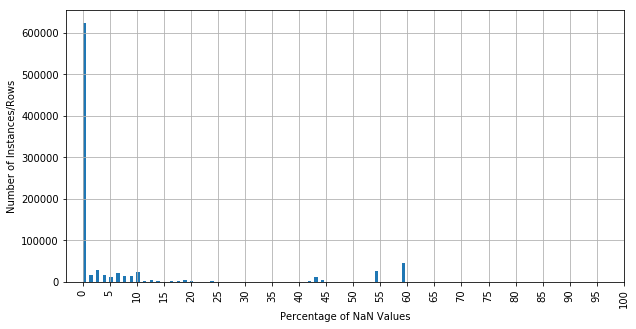

In [26]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))
plt.hist(Azdias_nan_percentage_by_row.values,100)
plt.ylabel("Number of Instances/Rows");
plt.xlabel("Percentage of NaN Values");
plt.xticks(np.arange(0, 101, step=5),rotation='vertical',fontsize=10)
plt.grid();

In [27]:
numberOfRows_missing_a_lot = len(Azdias_nan_percentage_by_row[Azdias_nan_percentage_by_row>30])
numberOfRows_missing_a_lot

93384

In [28]:
percent_of_defecient_rows = numberOfRows_missing_a_lot/len(Azdias_nan_percentage_by_row)*100

In [29]:
print(f"Percentage of rows missing a lot of data to total number of rows = {np.round(percent_of_defecient_rows,2)}%")

Percentage of rows missing a lot of data to total number of rows = 10.48%


In [30]:
def split_rows_by_missing_feature_percent(dataset,threshold):
    nan_count_by_row = dataset.isna().sum(axis=1)
    nan_percentage_by_row = nan_count_by_row/dataset.shape[1]*100
    missing_a_little_index = nan_percentage_by_row[nan_percentage_by_row<=threshold].index
    missing_a_lot_index = nan_percentage_by_row[nan_percentage_by_row>threshold].index
    return missing_a_little_index,missing_a_lot_index

In [31]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_a_little_index,missing_a_lot_index = split_rows_by_missing_feature_percent(azdias_reduced,30)
missing_a_lot_index.shape

(93384,)

In [42]:
def compare_features_distributions(feature):
    figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (12,3))
    sns.countplot(azdias_reduced.loc[missing_a_little_index,feature],ax=axs[0])
    axs[0].set_title("Rows missing <30% of data")
    sns.countplot(azdias_reduced.loc[missing_a_lot_index,feature],ax=axs[1])
    axs[1].set_title("Rows missing >30% of data")

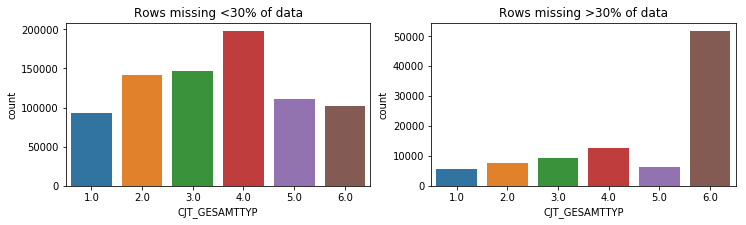

In [43]:
compare_features_distributions('CJT_GESAMTTYP')

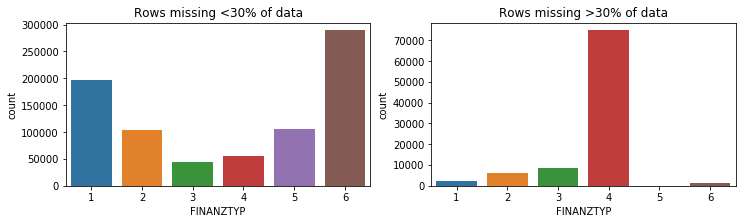

In [44]:
compare_features_distributions('FINANZTYP')

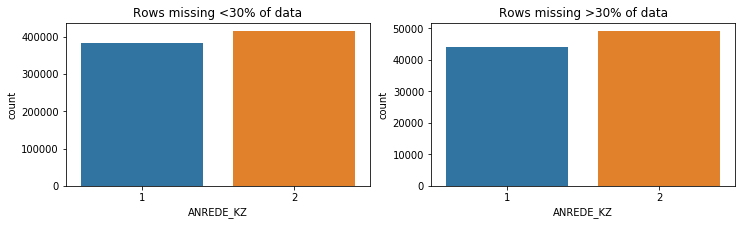

In [45]:
compare_features_distributions('ANREDE_KZ')

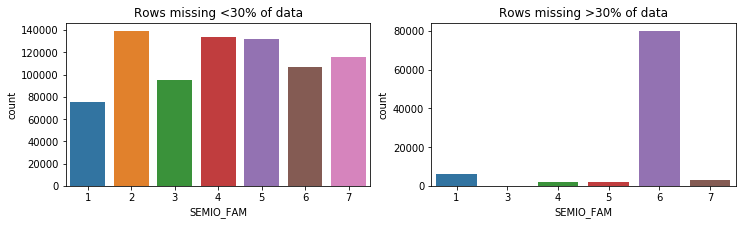

In [46]:
compare_features_distributions('SEMIO_FAM')

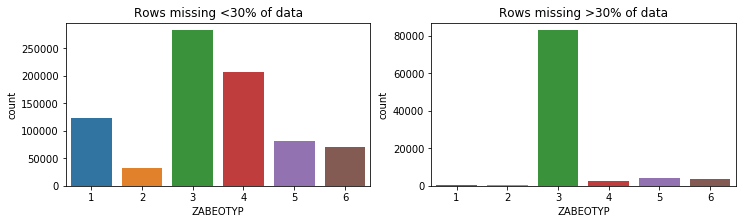

In [47]:
compare_features_distributions('ZABEOTYP')

<div class="alert alert-block alert-info">
<h3><b>Discussion 1.1.3: Assess Missing Data in Each Row</b></h3>
<ul>
    <li>Apparently, the distributions of the five features show that rows missing more than 30% of their data have different distributions when compared to rows that don't have much of missing data. Therefore, it's not correct to assume that rows with +30% missing data are safe to drop as they might be telling a different side of the story the data shows.</li>
    <li>Despite the previous point, these rows will be dropped for the sake of simplifying this exercise.
    </li>
</ul>

In [279]:
azdias_reduced2 = azdias_reduced.loc[missing_a_little_index]

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [280]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [281]:
def get_columns_by_type(columns_type,dataset):
    if type != None:
        all_columns = feat_info[feat_info['type'] == columns_type]['attribute'].values
    else:
        all_columns = feat_info['attribute'].values
    columns_in_dataset = dataset.columns.values
    return np.intersect1d(all_columns,columns_in_dataset)

In [282]:
# get all categorical features in our dataset
categorical_columns_in_reduced_set = get_columns_by_type("categorical",azdias_reduced2)

In [283]:
azdias_reduced2.loc[:,categorical_columns_in_reduced_set]

,ANREDE_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,CJT_GESAMTTYP,FINANZTYP,GEBAEUDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,OST_WEST_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP
1,2,8,8A,5.0,1,8.0,10.0,0,5.0,3.0,2.0,1.0,1.0,W,3.0,1.0,2.0,5
2,2,4,4C,3.0,1,1.0,10.0,1,1.0,1.0,3.0,2.0,1.0,W,2.0,0.0,1.0,5
3,2,2,2A,2.0,6,1.0,1.0,0,NaN,NaN,9.0,4.0,1.0,W,1.0,0.0,1.0,3
4,1,6,6B,5.0,5,1.0,5.0,0,10.0,5.0,3.0,2.0,1.0,W,2.0,0.0,2.0,4
5,2,8,8C,2.0,2,1.0,1.0,0,1.0,1.0,4.0,2.0,1.0,W,0.0,0.0,2.0,4
6,2,4,4A,5.0,4,1.0,12.0,0,1.0,1.0,2.0,1.0,1.0,W,1.0,0.0,1.0,4
7,1,2,2D,3.0,5,8.0,9.0,0,1.0,1.0,1.0,1.0,1.0,W,0.0,0.0,1.0,1
8,1,1,1A,3.0,6,3.0,3.0,1,1.0,1.0,10.0,5.0,1.0,W,3.0,0.0,2.0,6
9,2,1,1E,4.0,1,3.0,12.0,1,1.0,1.0,3.0,2.0,1.0,W,3.0,0.0,2.0,4
10,2,9,9D,1.0,6,1.0,8.0,0,1.0,1.0,1.0,1.0,1.0,W,2.0,0.0,2.0,3


In [284]:
def get_columns_metadata(dataset,columnset):
    metadata = pd.concat(
                        [
                            dataset.loc[:,columnset].nunique(),
                            dataset.loc[:,columnset].dtypes
                        ],
                        axis=1
                    )
    symboles = ['UniqueCount','DataType']
    metadata.columns = symboles
    result = metadata.join(feat_info.set_index('attribute'))
    result = result.drop('information_level',axis=1)
    result = result.drop('missing_or_unknown',axis=1)
    return result
    

In [296]:
# extract count for categorical features to distinguish binary from multi-category features
categorical_feature_count = get_columns_metadata(azdias_reduced2,categorical_columns_in_reduced_set)

In [287]:
binary_category_features = categorical_feature_count[categorical_feature_count['UniqueCount']<=2]
binary_category_features

,UniqueCount,DataType,type
ANREDE_KZ,2,int64,categorical
GREEN_AVANTGARDE,2,int64,categorical
OST_WEST_KZ,2,object,categorical
SOHO_KZ,2,float64,categorical
VERS_TYP,2,float64,categorical


<div class="alert alert-block alert-info">
Since One of the binary features is of type "Object", we will have to encode it in numeric format in order for it to be ready for the subsequent processing.
</div>

In [288]:
azdias_reduced2['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [289]:
azdias_reduced2['OST_WEST_KZ'].dtype

dtype('O')

In [290]:
azdias_reduced2['OST_WEST_KZ'] = azdias_reduced2['OST_WEST_KZ'].map({'W':1,'O':0})

In [291]:
azdias_reduced2['OST_WEST_KZ'].dtype

dtype('int64')

In [286]:
multicategory_features = categorical_feature_count[categorical_feature_count['UniqueCount']>2]
multicategory_features

,UniqueCount,DataType,type
CAMEO_DEUG_2015,9,object,categorical
CAMEO_DEU_2015,44,object,categorical
CJT_GESAMTTYP,6,float64,categorical
FINANZTYP,6,int64,categorical
GEBAEUDETYP,7,float64,categorical
GFK_URLAUBERTYP,12,float64,categorical
LP_FAMILIE_FEIN,11,float64,categorical
LP_FAMILIE_GROB,5,float64,categorical
LP_STATUS_FEIN,10,float64,categorical
LP_STATUS_GROB,5,float64,categorical


<div class="alert alert-block alert-info">
The rest of the categorical features (all multi-category features) will be dropped to simplify the exercise.
</div>

In [292]:
azdias_reduced3 = azdias_reduced2.drop(multicategory_features.index.values,axis=1)

In [293]:
azdias_reduced3.shape

(797837, 66)

In [294]:
# column set after dropping the multi-category features
azdias_reduced3.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE',
       'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA

<div class="alert alert-block alert-info">
<h3><b>Discussion 1.2.1: Re-Encode Categorical Features</b></h3>

<ul>
    <li>Since One of the binary features in the dataset is of type "Object", I have re-encoded it in numeric format in order for it to be ready for the subsequent processing. </li>
    <li>For the rest of the categorical features (all multi-category features), they were dropped to simplify the exercise.</li>
</ul>
</div>

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [47]:
def create_new_feature_from_map(dataset,old_feature,new_feature,map):
    dataset[new_feature] = dataset[old_feature]
    dataset[new_feature].replace(map_PRAEGENDE_JUGENDJAHRE_to_decade,inplace=True)
    return dataset

In [48]:
map_PRAEGENDE_JUGENDJAHRE_to_decade = {1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,
                                       9:70,10:80,11:80,12:80,13:80,14:90,15:90}

In [49]:
azdias_reduced3 = create_new_feature_from_map(
    azdias_reduced3,'PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_DECADE',map_PRAEGENDE_JUGENDJAHRE_to_decade
)

In [50]:
map_PRAEGENDE_JUGENDJAHRE_to_movement = {1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}

In [51]:
azdias_reduced3 = create_new_feature_from_map(
    azdias_reduced3,'PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_MOVEMENT',map_PRAEGENDE_JUGENDJAHRE_to_movement
)

In [52]:
map_CAMEO_INTL_2015_to_wealth = {'-1':np.nan,'11':1,'12':1,'13':1,'14':1,'15':1,
                                 '21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,
                                 '33':3,'34':3,'35':3,'41':4,'42':4,'43':4,'44':4,
                                 '45':4,'51':5,'52':5,'53':5,'54':5,'55':5,'XX':np.nan}

In [53]:
azdias_reduced3 = create_new_feature_from_map(
    azdias_reduced3,'CAMEO_INTL_2015','CAMEO_INTL_2015_WEALTH',map_CAMEO_INTL_2015_to_wealth
)

In [54]:
map_CAMEO_INTL_2015_to_lifestage = {'-1':np.nan,'11':1,'12':2,'13':3,'14':4,'15':5,
                                    '21':1,'22':2,'23':3,'24':4,'25':5,'31':1,'32':2,
                                    '33':3,'34':4,'35':5,'41':1,'42':2,'43':3,'44':4,
                                    '45':5,'51':1,'52':2,'53':3,'54':4,'55':5,'XX':np.nan}

In [55]:
azdias_reduced3 = create_new_feature_from_map(
    azdias_reduced3,'CAMEO_INTL_2015','CAMEO_INTL_2015_LIFESTAGE',map_CAMEO_INTL_2015_to_lifestage
)

In [56]:
mixed_columns = get_columns_by_type('mixed',azdias_reduced3)

In [57]:
azdias_reduced3 = azdias_reduced3.drop(mixed_columns,axis=1)

In [58]:
azdias_reduced3['CAMEO_INTL_2015_WEALTH'] = pd.to_numeric(azdias_reduced3['CAMEO_INTL_2015_WEALTH'], errors='coerce')
azdias_reduced3['CAMEO_INTL_2015_LIFESTAGE'] = pd.to_numeric(azdias_reduced3['CAMEO_INTL_2015_LIFESTAGE'], errors='coerce')

<div class="alert alert-block alert-info">
<h3><b>Discussion 1.2.2: Engineer Mixed-Type Features</b></h3>
    <ul>
        <li>From the mixed-type feature "PRAEGENDE_JUGENDJAHRE", two new features were extracted:</li>
            <ul>
                <li>"PRAEGENDE_JUGENDJAHRE_DECADE" which indicates the decade of birth of the population member.</li>
                <li>"PRAEGENDE_JUGENDJAHRE_MOVEMENT" which indicates the cultural movement of the generation to which the population member belongs (namely, Mainstream or Avantgarde).</li>
            </ul>
        <li>From the mixed-type feature "CAMEO_INTL_2015", two new features were extracted:</li>
            <ul>
                <li>"CAMEO_INTL_2015_WEALTH" which indicates the level of wealth of the population member (namely, poor, less-affluent, confortable, properous, or wealthy).</li>
                <li>"CAMEO_INTL_2015_LIFESTAGE" which indicates the life stage of the population member (namely, Pre-family couples and singles, young couples with children, families with school age children, older families and mature couples, or elders in retirement).</li>
            </ul>
        <li>The original "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" features have been discarded along with all the remaining mixed-type features. Although more feature engineering can be done here, I decided to drop these features in order to simplify the exercise.</li>
    <ul>
        
</div>

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [59]:
azdias_reduced3.shape

(797837, 64)

In [60]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
get_columns_metadata(azdias_reduced3,azdias_reduced3.columns.values)


,UniqueCount,DataType,type
ALTERSKATEGORIE_GROB,4,float64,ordinal
ANREDE_KZ,2,int64,categorical
FINANZ_MINIMALIST,5,int64,ordinal
FINANZ_SPARER,5,int64,ordinal
FINANZ_VORSORGER,5,int64,ordinal
FINANZ_ANLEGER,5,int64,ordinal
FINANZ_UNAUFFAELLIGER,5,int64,ordinal
FINANZ_HAUSBAUER,5,int64,ordinal
GREEN_AVANTGARDE,2,int64,categorical
HEALTH_TYP,3,float64,ordinal


<div class="alert alert-block alert-info">
As per the above-shown dataframe, all 64 features remaining in our dataset are of numeric types. The handling of missing values (NaNs) will follow in the data Imputation step later on.
</div>

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [62]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df = recode_dataset(customers)
    df_reduced=df.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'],axis=1)

    missing_a_little_index,missing_a_lot_index = split_rows_by_missing_feature_percent(df_reduced,30)
    df_reduced2 = df_reduced.loc[missing_a_little_index]

    categorical_columns_in_reduced_set = get_columns_by_type("categorical",df_reduced2)
    categorical_feature_count = get_columns_metadata(df_reduced2,categorical_columns_in_reduced_set)

    multicategory_features = categorical_feature_count[categorical_feature_count['UniqueCount']>2]
    binary_category_features = categorical_feature_count[categorical_feature_count['UniqueCount']<=2]

    map_OST_WEST_KZ = {'W': 0, 'O': 1}
    df_reduced2 = df_reduced2.replace({'OST_WEST_KZ':map_OST_WEST_KZ})

    df_reduced3 = df_reduced2.drop(multicategory_features.index.values,axis=1)


    df_reduced3 = create_new_feature_from_map(
        df_reduced3,'PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_DECADE',map_PRAEGENDE_JUGENDJAHRE_to_decade
    )

    df_reduced3 = create_new_feature_from_map(
        df_reduced3,'PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_MOVEMENT',map_PRAEGENDE_JUGENDJAHRE_to_movement
    )

    df_reduced3 = create_new_feature_from_map(
        df_reduced3,'CAMEO_INTL_2015','CAMEO_INTL_2015_WEALTH',map_CAMEO_INTL_2015_to_wealth
    )

    df_reduced3 = create_new_feature_from_map(
        df_reduced3,'CAMEO_INTL_2015','CAMEO_INTL_2015_LIFESTAGE',map_CAMEO_INTL_2015_to_lifestage
    )

    mixed_columns = get_columns_by_type('mixed',df_reduced3)

    df_reduced3 = df_reduced3.drop(mixed_columns,axis=1)

    df_reduced3['CAMEO_INTL_2015_WEALTH'] = pd.to_numeric(df_reduced3['CAMEO_INTL_2015_WEALTH'], errors='coerce')
    df_reduced3['CAMEO_INTL_2015_LIFESTAGE'] = pd.to_numeric(df_reduced3['CAMEO_INTL_2015_LIFESTAGE'], errors='coerce')
    return df_reduced3
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [63]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
dataImputer = Imputer(missing_values=np.nan, strategy='most_frequent',axis=0)
azdias_imputed = dataImputer.fit_transform(azdias_reduced3)

In [64]:
# Apply feature scaling to the general population demographics data.
dataScaler = StandardScaler()
azdias_scaled = dataScaler.fit_transform(azdias_imputed)


<div class="alert alert-block alert-info">
<h3><b>Discussion 2.1: Apply Feature Scaling</b></h3>
    <ul>
        <li>Missing data (NaN values) have been imputed with the most frequent values for their columns. This is certainly not the best strategy since the features are a mix of numerical, categorical, and ordinal types. In a more thourough exercise, median value imputation can be performed for the numerical and ordinal types while most frequent values imputation can be reserved for categorical features.</li>
        <li>In terms of scaling, a Standardization scaler has been used to scale the values. In general, this is the most likely to be the best option with our data as it binds the values to be within 0 and 1 for the most part; hence, reducing any bias in the analysis and clustering steps to follow.</li>
    </ul>
</div>

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [65]:
from matplotlib.ticker import MaxNLocator
def scree_plot(pca):
    numberOfComponents = pca.n_components_
    explainedVariance_Incremental = pca.explained_variance_ratio_*100
    explainedVariance_Cumulative = np.cumsum(explainedVariance_Incremental)
    
    
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    
       
    ax.bar(np.arange(numberOfComponents), explainedVariance_Incremental,color='blue')
    ax.plot(np.arange(numberOfComponents), explainedVariance_Cumulative,color='red')
    
    ax.xaxis.set_tick_params(width=2)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=14))
    ax.set_xlim([-1,65])
    ax.set_xlabel("Principal Components Sequenced by Ratio of Explained Variance")
    
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=20))
    ax.set_ylim([0,100])
    ax.set_ylabel("Variance Explained (%)")
    
    plt.title('Explained Variance Per Principal Component')
    plt.grid()
    
    

In [66]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca_components = PCA()

azdias_pca = pca_components.fit_transform(azdias_scaled)

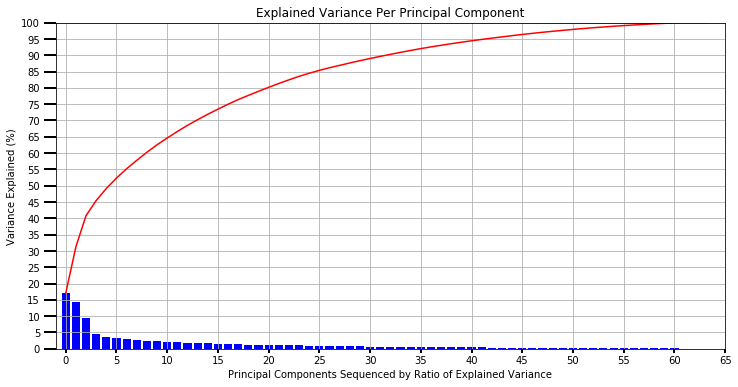

In [67]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca_components)

<div class="alert alert-block alert-info">
Since 30 Principal Components will be able to explain more than 85% of the variance in our data, the number of Principal components will be reduced to 30 components.
</div>



In [68]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_less_components = PCA(30)

azdias_compressed = pca_less_components.fit_transform(azdias_scaled)


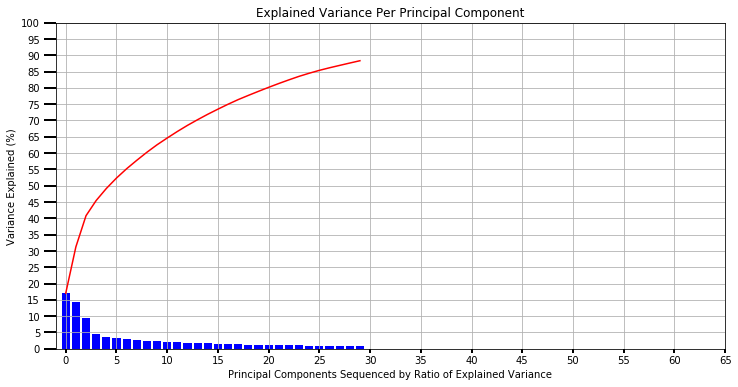

In [69]:
scree_plot(pca_less_components)

<div class="alert alert-block alert-info">
    <h3><b>Discussion 2.2: Perform Dimensionality Reduction</b></h3>
    <ul>
        <li>Since 30 Principal Components will be able to explain more than 85% of the variance in our data, the number of Principal Components will be reduced to 30 components.</li>
    </ul>
</div>

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [70]:
pca_less_components.components_.shape

(30, 64)

In [71]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

#print(dir(pca_less_components.components_))
def print_component_most_signigicat_features(PCA_Components,component_number):
    print(f"Most Significant features in Component# {component_number}:")
    feature_weights = pd.DataFrame(PCA_Components.components_,columns=azdias_reduced3.columns)
    print(feature_weights.loc[component_number,:].sort_values(ascending=False)[[0,1,2,3,60,61,62,63]])


In [72]:
print_component_most_signigicat_features(pca_less_components,0)
print("-------------------")
print_component_most_signigicat_features(pca_less_components,1)
print("-------------------")
print_component_most_signigicat_features(pca_less_components,2)

Most Significant features in Component# 0:
PLZ8_ANTG3                   0.216864
PLZ8_ANTG4                   0.207830
CAMEO_INTL_2015_LIFESTAGE    0.199200
CAMEO_INTL_2015_WEALTH       0.199200
KBA05_GBZ                   -0.206482
MOBI_REGIO                  -0.215544
PLZ8_ANTG1                  -0.216879
FINANZ_MINIMALIST           -0.223324
Name: 0, dtype: float64
-------------------
Most Significant features in Component# 1:
ALTERSKATEGORIE_GROB              0.240049
FINANZ_VORSORGER                  0.221317
SEMIO_ERL                         0.203501
SEMIO_LUST                        0.169725
FINANZ_SPARER                    -0.221619
SEMIO_REL                        -0.229235
PRAEGENDE_JUGENDJAHRE_MOVEMENT   -0.237335
PRAEGENDE_JUGENDJAHRE_DECADE     -0.237335
Name: 1, dtype: float64
-------------------
Most Significant features in Component# 2:
SEMIO_VERT    0.347744
SEMIO_SOZ     0.268968
SEMIO_FAM     0.264978
SEMIO_KULT    0.254068
SEMIO_KRIT   -0.283705
SEMIO_DOM    -0.3188

<div class="alert alert-block alert-info">
<h3><b>Discussion 2.3: Interpret Principal Components</b></h3>
    <ul>
        <li>The first Principal Component (and the most significant one) has significant weights for the features (LZ8_ANTG3, PLZ8_ANTG4, CAMEO_INTL_2015_LIFESTAGE, CAMEO_INTL_2015_WEALTH, KBA05_GBZ, MOBI_REGIO, PLZ8_ANTG1, FINANZ_MINIMALIST) which are mostly indicative of socio-economic status of the indiduals.</li>
        <li> The second Principal Component has significant weights for the features (ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, SEMIO_ERL, SEMIO_LUST, FINANZ_SPARER, SEMIO_REL, PRAEGENDE_JUGENDJAHRE_MOVEMENT, PRAEGENDE_JUGENDJAHRE_DECADE) which are mostly indicative of different age groups and their financial behavior.</li>
        <li> The thrid Principal Component has significant weights for the features (SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM, ANREDE_KZ) which are mostly indicative of the gender and psychology of the individuals.</li>
    </ul>
            
</div>

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [73]:
def get_KMeans_clustering_score(dataset,numberOfCluster):
    KM = KMeans(n_clusters = numberOfCluster)
    model = KM.fit(dataset)
    return np.abs(model.score(dataset))


In [74]:
number_of_centroids = list(range(1,30,1))

In [75]:
scores = []

In [223]:
from datetime import datetime
with active_session():
    for n in number_of_centroids:
        start = datetime.now()
        print(f"{start} - started with {n}")
        score = get_KMeans_clustering_score(azdias_compressed,n)
        end = datetime.now()
        print(f"{end} - finished with {n}")
        print(f"duration is {end-start}")
        print(f"score is {score}")
        scores.append(score)

2019-09-30 18:26:59.618797 - started with 1
2019-09-30 18:27:04.775164 - finished with 1
duration is 0:00:05.156367
score is 45092078.05243822
2019-09-30 18:27:04.775840 - started with 2
2019-09-30 18:27:23.757064 - finished with 2
duration is 0:00:18.981224
score is 38617509.60255966
2019-09-30 18:27:23.757761 - started with 3
2019-09-30 18:28:00.864736 - finished with 3
duration is 0:00:37.106975
score is 35047253.6552301
2019-09-30 18:28:00.865419 - started with 4
2019-09-30 18:28:54.043423 - finished with 4
duration is 0:00:53.178004
score is 32853889.46042348
2019-09-30 18:28:54.044157 - started with 5
2019-09-30 18:29:36.943498 - finished with 5
duration is 0:00:42.899341
score is 31421357.94484746
2019-09-30 18:29:36.944221 - started with 6
2019-09-30 18:30:48.557782 - finished with 6
duration is 0:01:11.613561
score is 30157940.937939208
2019-09-30 18:30:48.558476 - started with 7
2019-09-30 18:32:02.741816 - finished with 7
duration is 0:01:14.183340
score is 29050597.65109196

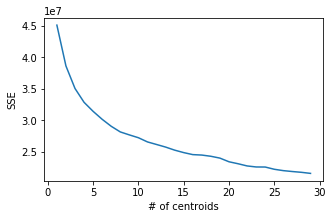

In [224]:
plt.figure(figsize=(5,3))
plt.plot(number_of_centroids,scores)
plt.xlabel('# of centroids')
plt.ylabel('SSE');

<div class="alert alert-block alert-info">
Despite the fact that there is no obvious elbow on the scree plot above, we still can see that the decrease rate slows down after 10 centroids. Accordingly, we can take 10 as our optimal number of centroids.
</div>

In [160]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

KM = KMeans(n_clusters = 10,random_state=42)
model = KM.fit(azdias_compressed)
score = np.abs(model.score(azdias_compressed))
azdias_KM_labels = model.predict(azdias_compressed)

<div class="alert alert-block alert-info">
<h3><b>Discussion 3.1: Apply Clustering to General Population</b></h3>
    <ul>
        <li> Multiple attempts to generate a rough scree plot for the KMeans clustering failed to locate a proper elbow using which the number of clusters is to be determined.</li>
        <li> Subsequently, a full-fledged scree plot form 1 cluster to 30 clusters incremented by 1 for each iteration was generated</li>
        <li> From the final scree plot, it obvious that there is not a clear elbow using which the clustering is to be made.</li>
        <li> Accordingly, the semi-arbitrary number of 10 clusters was selected due to the fact that the scree plot slows down after it sinificantly.</li>
        <li> In any subsequent effort to revise the clustering here, I would recommend trying another clustering algorithm since KMeans does not seem to be able to find good chunks in the data.</li>
    </ul>
</div>

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [161]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [162]:
customers.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [163]:
customers.shape

(191652, 85)

In [164]:
customers_cleaned = clean_data(customers)

In [165]:
customers_cleaned.shape

(141690, 64)

In [166]:
uniquevalues = []
for column in customers_cleaned.columns.values:
    line = [column,customers_cleaned[column].unique()]
    uniquevalues.append(line)
uniquevalues

[['ALTERSKATEGORIE_GROB', array([  4.,   3.,   2.,   1.,  nan])],
 ['ANREDE_KZ', array([1, 2])],
 ['FINANZ_MINIMALIST', array([5, 3, 2, 4, 1])],
 ['FINANZ_SPARER', array([1, 2, 3, 4, 5])],
 ['FINANZ_VORSORGER', array([5, 4, 1, 2, 3])],
 ['FINANZ_ANLEGER', array([1, 2, 4, 3, 5])],
 ['FINANZ_UNAUFFAELLIGER', array([2, 4, 1, 5, 3])],
 ['FINANZ_HAUSBAUER', array([2, 4, 3, 5, 1])],
 ['GREEN_AVANTGARDE', array([1, 0])],
 ['HEALTH_TYP', array([  1.,   2.,   3.,  nan])],
 ['RETOURTYP_BK_S', array([  5.,   3.,   2.,   4.,   1.,  nan])],
 ['SEMIO_SOZ', array([6, 2, 4, 3, 5, 7, 1])],
 ['SEMIO_FAM', array([5, 2, 4, 3, 7, 1, 6])],
 ['SEMIO_REL', array([2, 1, 3, 4, 5, 6, 7])],
 ['SEMIO_MAT', array([6, 3, 4, 1, 5, 2, 7])],
 ['SEMIO_VERT', array([6, 3, 7, 5, 2, 1, 4])],
 ['SEMIO_LUST', array([7, 5, 6, 4, 2, 1, 3])],
 ['SEMIO_ERL', array([3, 7, 4, 2, 6, 5, 1])],
 ['SEMIO_KULT', array([4, 1, 5, 6, 7, 2, 3])],
 ['SEMIO_RAT', array([1, 2, 3, 5, 6, 4, 7])],
 ['SEMIO_KRIT', array([3, 7, 5, 1, 6, 2, 4])],
 [

In [167]:
customers_imputed = dataImputer.transform(customers_cleaned)
customers_scaled = dataScaler.transform(customers_imputed)


In [168]:
customers_compressed = pca_less_components.transform(customers_scaled)

In [169]:
customer_preds = model.predict(customers_compressed)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [170]:
general_labels = pd.DataFrame(azdias_KM_labels)
customers_labels = pd.DataFrame(customer_preds)

In [171]:
general_count = general_labels[0].value_counts()
customer_count = customers_labels[0].value_counts()

In [172]:
df_counts = pd.concat([general_count,customer_count],axis=1)
df_counts.columns =['General_Count','Customer_Count']

In [173]:
df_counts['General_%'] = df_counts['General_Count']/len(azdias_KM_labels)*100
df_counts['Customer_%'] = df_counts['Customer_Count']/len(customer_preds)*100
df_counts['Representation_Ratio'] = df_counts['Customer_%']/df_counts['General_%']

In [174]:
df_counts = df_counts.sort_values(by=['Representation_Ratio']).reset_index()

In [175]:
df_counts

,index,General_Count,Customer_Count,General_%,Customer_%,Representation_Ratio
0,5,85587,1406,10.727379,0.992307,0.092502
1,4,69539,1483,8.715941,1.046651,0.120085
2,3,92048,2692,11.537194,1.899922,0.164678
3,6,73581,4422,9.222560,3.120898,0.338398
4,7,48943,6477,6.134461,4.571247,0.745175
5,0,92380,13758,11.578806,9.709930,0.838595
6,9,92002,18520,11.531428,13.070788,1.133493
7,1,118794,24739,14.889508,17.459948,1.172634
8,2,121721,65415,15.256374,46.167690,3.026125
9,8,3242,2778,0.406349,1.960618,4.824965


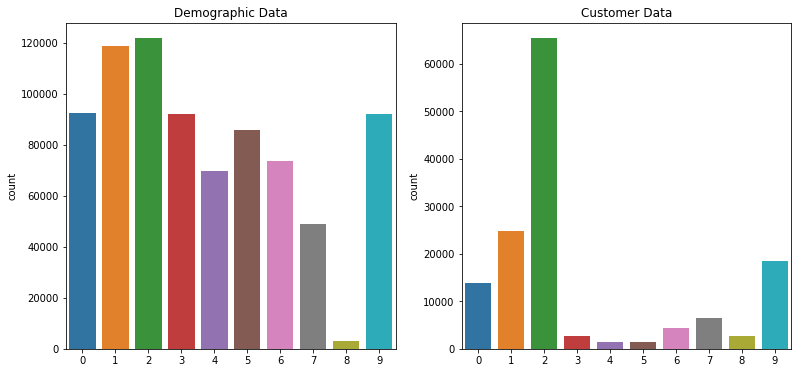

In [176]:
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (13,6))
sns.countplot(azdias_KM_labels,ax=axs[0])
axs[0].set_title("Demographic Data")
sns.countplot(customer_preds,ax=axs[1])
axs[1].set_title("Customer Data");

In [319]:
def get_raw_centroid_dimensions(clusters_numbers):
    cluster_centroids = model.cluster_centers_[clusters_numbers]
    decompressed_centroids = pca_less_components.inverse_transform(cluster_centroids)
    unscaled_centroids = dataScaler.inverse_transform(decompressed_centroids)
    raw_centroids = pd.DataFrame(unscaled_centroids, columns = customers_cleaned.columns)    
    return raw_centroids
    

In [320]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
df_counts[7:10]

,index,General_Count,Customer_Count,General_%,Customer_%,Representation_Ratio
7,1,118794,24739,14.889508,17.459948,1.172634
8,2,121721,65415,15.256374,46.167690,3.026125
9,8,3242,2778,0.406349,1.960618,4.824965


In [408]:
get_raw_centroid_dimensions(df_counts[7:10]['index'].values)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,3.483062,1.933919,3.946989,1.659027,4.211380,2.518895,2.025086,2.610281,0.384679,2.114746,3.470805,2.871629,2.038217,2.104382,2.369158,3.132938,5.049420,6.383101,2.066759,3.487323,5.723716,5.701339,5.593103,2.992201,2.708475,0.008956,1.410044,1.978671,-0.000134,3.301751,4.080130,8.398609,1.923227,0.006338,3.875789,1993.648352,0.833278,2.523873,1.008402,0.067636,0.017037,4.099341,4.918056,2.935392,5.527272,4.054597,2.638602,4.027812,2.914520,4.281299,695.863592,2.928443,2.325438,0.917393,0.213180,3.430654,3.879209,2.738048,3.988828,2.493630,65.510378,65.510378,25.628202,25.628202
1,3.339112,1.076709,4.752828,1.538994,4.324240,1.810606,1.867439,2.018798,0.385418,2.195260,3.904756,4.673757,4.683638,3.632508,3.585863,5.993223,5.020496,4.273386,4.801052,2.622018,3.437914,3.194886,2.607146,3.192798,2.970486,0.009092,1.566451,1.986927,-0.000105,3.210585,4.347867,8.397349,1.986451,0.005843,3.821177,1993.549678,0.845265,2.506012,1.009009,0.083737,0.017486,4.083445,4.908284,2.942572,5.486850,4.054436,2.651420,4.011176,2.864958,4.300487,687.214904,2.925906,2.306598,0.903171,0.217676,3.430409,3.875913,2.744625,3.971766,2.497469,64.852310,64.852310,25.543901,25.543901
2,3.094646,1.457001,3.472944,2.125172,3.859978,2.167715,2.396909,3.217169,0.672138,2.185676,3.871264,4.251543,4.033812,3.605023,3.929341,4.599277,5.074896,4.708817,3.852912,3.544126,4.496323,4.552259,4.113818,3.656159,3.379175,0.010851,1.591656,2.221900,1.017357,3.519529,4.432180,8.394639,10.483472,1.862995,2.611264,1992.841025,0.802726,1.471537,1.250293,0.337202,0.380870,3.173978,3.637521,4.317624,4.260880,3.322942,2.172725,2.871298,2.455709,3.722365,640.684677,2.107423,2.868490,1.750135,0.827321,3.741862,3.324021,3.150045,5.881229,3.161481,68.626645,68.626645,31.972304,31.972304


In [382]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
df_counts[0:3]

,index,General_Count,Customer_Count,General_%,Customer_%,Representation_Ratio
0,5,85587,1406,10.727379,0.992307,0.092502
1,4,69539,1483,8.715941,1.046651,0.120085
2,3,92048,2692,11.537194,1.899922,0.164678


In [409]:
get_raw_centroid_dimensions(df_counts[0:3]['index'].values)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,1.692474,2.002700,1.184264,4.296561,2.196665,4.169685,3.741309,4.157627,0.049001,2.315966,2.655530,3.207273,3.930640,5.359621,4.935701,2.225510,3.158619,4.324434,4.102147,6.119697,5.532801,6.140791,6.111893,6.196754,5.515044,0.008158,1.541234,1.460073,0.000181,5.589203,4.207603,7.308911,13.422287,0.042075,2.090895,1992.501823,0.747400,0.426254,1.331084,1.171508,0.554620,2.222226,3.259353,5.152637,3.394929,3.431344,2.881022,1.800320,3.000410,5.044175,536.264595,1.513656,3.324377,2.383239,1.223512,3.752109,2.768827,3.659226,6.884833,3.728706,87.124203,87.124203,45.777521,45.777521
1,1.887812,0.972826,1.906586,4.333571,2.143469,3.556463,3.768185,3.605920,0.125084,2.394212,2.825982,6.637409,6.678002,6.227792,5.060029,6.022335,3.053811,2.280448,6.795079,4.064245,2.825479,2.883863,2.483001,5.586563,4.739651,0.008082,1.529366,1.429394,0.000342,5.460167,4.561482,7.172164,14.665614,0.045939,2.097371,1992.667577,0.703594,0.384673,1.288488,1.134604,0.597276,2.202643,3.204839,5.097750,3.382468,3.369048,2.874418,1.741665,2.988665,4.939118,534.247222,1.474384,3.306140,2.402343,1.250580,3.741730,2.715405,3.681322,6.898736,3.722548,87.163965,87.163965,46.238296,46.238296
2,1.899528,1.971704,2.400340,3.939551,2.300437,4.381295,3.894602,2.724942,0.218733,2.338078,2.525815,2.667123,3.612116,4.973901,4.844551,2.576316,3.259679,4.522063,3.821509,5.896517,5.466911,5.910723,5.573749,5.753517,5.385939,0.008383,1.470299,2.012011,0.000272,3.921838,3.387639,7.545160,3.321627,0.003055,3.737634,1994.272921,0.858827,2.064756,1.164931,0.217208,0.033965,3.873717,4.914364,2.963436,5.482737,4.003439,2.646371,3.581408,3.550950,4.373976,721.533255,2.818319,2.417697,1.002101,0.236020,3.504152,3.891717,2.730262,3.959426,2.487054,86.986479,86.986479,27.547847,27.547847


In [395]:
df_counts.loc[[0,9]]

,index,General_Count,Customer_Count,General_%,Customer_%,Representation_Ratio
0,5,85587,1406,10.727379,0.992307,0.092502
9,8,3242,2778,0.406349,1.960618,4.824965


In [403]:
two_centroids = get_raw_centroid_dimensions(df_counts.loc[[0,9],:]['index'].values)
two_centroids.index = ['cl5_UnderRep','cl8_OverRep']

In [404]:
two_centroids = two_centroids.T

In [405]:
two_centroids['cl5_ratio_cl8'] = two_centroids['cl5_UnderRep']/two_centroids['cl8_OverRep']

In [406]:
ratio_filter = 1.7
ratio_filter_reciprocal = 1/ratio_filter

In [407]:
two_centroids_filtered = two_centroids[(two_centroids['cl5_ratio_cl8'] >= ratio_filter) | (two_centroids['cl5_ratio_cl8'] <=ratio_filter_reciprocal )]
two_centroids_filtered.sort_values(by='cl5_ratio_cl8')

,cl5_UnderRep,cl8_OverRep,cl5_ratio_cl8
ANZ_TITEL,0.000181,1.017357,0.000177
ANZ_HH_TITEL,0.042075,1.862995,0.022585
GREEN_AVANTGARDE,0.049001,0.672138,0.072903
KBA05_ANTG1,0.426254,1.471537,0.289666
FINANZ_MINIMALIST,1.184264,3.472944,0.340997
SEMIO_VERT,2.225510,4.599277,0.483883
ALTERSKATEGORIE_GROB,1.692474,3.094646,0.546904
FINANZ_VORSORGER,2.196665,3.859978,0.569087
SEMIO_RAT,6.119697,3.544126,1.726715
FINANZ_ANLEGER,4.169685,2.167715,1.923539


<div class="alert alert-block alert-info">
<h3><b>Discussion 3.3: Compare Customer Data to Demographics Data</b></h3>
<ul>
    <li>As per cluster 8 (which is over-represented in the customer dataset), the company seems to be very popular with the individuals characterized by being: middle-aged or senior (ALTERSKATEGORIE_GROB = 3.09), living with or around people with academic degrees (ANZ_TITEL=1.01, ANZ_HH_TITEL=1.86), rational-minded (SEMIO_RAT=3.54), money-saving (FINANZ_SPARER=2.12), and money-invisting (FINANZ_ANLEGER=2.16) individuals.</li>
    <li>As per cluster 5 (which is under-represented in the customers dataset), the company is also not very popular with the individuals characterized by being: young (below 40) (ALTERSKATEGORIE_GROB=1.69), living with or around people with not much of academic qualifications (ANZ_TITEL=0.00018, ANZ_HH_TITEL=0.042), dreamful (SEMIO_VERT=2.22), irrational (SEMIO_RAT = 6.11), and mainstream-minded (GREEN_AVANTGARDE=0.049) individuals.</li>
</ul>
</div>


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.